In [1]:
#我们选择doc2vec里面的dm和dbow结合的方式

In [2]:
# 首先导包
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [3]:
# 对训练测试及预测数据进行清理的def
def data_clean(data):
    replace_list = ['"', "'", '(', ')', '{', '}', '[', ']', ';', ':', ',', '\n', '<br />']
    for i in replace_list:
        data = [x.lower().replace(i, '') for x in data]
#     将标点视为一个单词
    comma = ['.', '!', '?']
    for i in comma:
        data = [x.replace(i, ' %s ' % i) for x in data]
    data = [x.split() for x in data]
    return data

In [4]:
# 从模型中获得训练过的向量
def getVecs(model, data, size):
    vecs = [np.array(model[x.tags[0]]).reshape((1, size)) for x in data]
    return np.concatenate(vecs)

In [5]:
# 读数据
train_data_df = pd.read_csv('train.csv')
predict_data_df = pd.read_csv('test_data.csv')

In [6]:
# 我们先观察一下训练样本
train_data_df

,Unnamed: 0,review,sentiment
0,15641,I have remembered this cartoon for over 50 yea...,positive
1,5969,Good Lord... How this ended up in our DVD play...,positive
2,38781,I've often wondered just how much CASPER was m...,positive
3,41290,"First of all, I don't understand why some peop...",positive
4,43206,After 7 years of watching that dreadful nonsen...,positive
...,...,...,...
39995,13779,Add pure humor + quick and unique sentences + ...,positive
39996,29638,Despite strong performances by Minnie Driver a...,negative
39997,26231,"Well, the big money machine has done it again!...",negative
39998,8250,This is an extremely-powerful based-on-a-true ...,positive


In [7]:
# 好坏设成01
train_data_df['result'] = train_data_df['sentiment'].apply(lambda x: 1 if x == 'negative' else 0)

In [8]:
# 看一下好坏的占比，基本55，那就不用动了
pd.DataFrame(pd.pivot_table(train_data_df, values= 'review',columns = ['result'],aggfunc='count'))

result,0,1
review,20014,19986


In [9]:
# 分下样本
x_train, x_test, y_train, y_test = train_test_split(train_data_df['review'], train_data_df['result'], test_size=0.3)

In [10]:
x_train = data_clean(x_train)
x_test = data_clean(x_test)
predict_x = data_clean(predict_data_df['review'])

In [11]:
# 把各个doc打个标签
x_train = [TaggedDocument(doc, ['train' + str(i)]) for i, doc in enumerate(x_train)]
x_test = [TaggedDocument(doc, ['test' + str(i)]) for i, doc in enumerate(x_test)]
predict_x = [TaggedDocument(doc, ['predict' + str(i)]) for i, doc in enumerate(predict_x)]

In [12]:
model_dm = Doc2Vec(window=10, vector_size=100, negative=5, dm=1, workers=5)
model_dbow = Doc2Vec(window=10, vector_size=100, negative=5, dm=0, workers=5)

In [13]:
# # 对所有评论创建词汇表
vocab_list = []
vocab_list.extend(x_train)
vocab_list.extend(x_test)
vocab_list.extend(predict_x)
model_dm.build_vocab(vocab_list)
model_dbow.build_vocab(vocab_list)


In [14]:
# 获得训练集向量
model_dm.train(x_train,total_examples=model_dm.corpus_count, epochs=model_dm.epochs)
model_dbow.train(x_train,total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

train_vecs_dm = getVecs(model_dm, x_train, 100)
train_vecs_dbow = getVecs(model_dbow, x_train, 100)
train_vecs = np.hstack((train_vecs_dm, train_vecs_dbow))

In [15]:
# 获得测试集向量

model_dm.train(x_test,total_examples=model_dm.corpus_count, epochs=model_dm.epochs)
model_dbow.train(x_test,total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

test_vecs_dm = getVecs(model_dm, x_test, 100)
test_vecs_dbow = getVecs(model_dbow, x_test, 100)
test_vecs = np.hstack((test_vecs_dm, test_vecs_dbow))

In [16]:
# 获得预测集向量

model_dm.train(predict_x,total_examples=model_dm.corpus_count, epochs=model_dm.epochs)
model_dbow.train(predict_x,total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

predict_vecs_dm = getVecs(model_dm, predict_x, 100)
predict_vecs_dbow = getVecs(model_dbow, predict_x, 100)
predict_vecs = np.hstack((predict_vecs_dm, predict_vecs_dbow))


Test Accuracy: 0.81


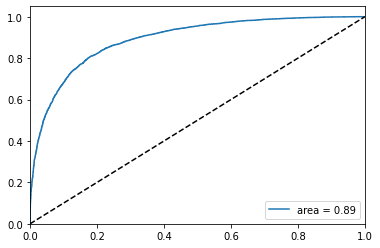

In [17]:
# 放入分类模型

rf_model = RandomForestClassifier(max_depth=5, random_state=255)
rf_model.fit(train_vecs, y_train)
print('Test Accuracy: %.2f' % rf_model.score(test_vecs, y_test))
pred_probas = rf_model.predict_proba(test_vecs)[:, 1]
fpr, tpr, _ = roc_curve(y_test, pred_probas)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='area = %.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.show()



In [18]:
# 我们预测下预测集
final_predict = rf_model.predict(predict_vecs)

In [19]:
# 将数据存入dataframe
predict_data_df['prediction'] = final_predict

In [20]:
predict_data_df['prediction'] = predict_data_df['prediction'].apply(lambda x: 'positive' if x == 0 else 'negative')

In [21]:
# 将数据存入excel
predict_data_df.to_csv('result.csv')